# Feature Engineering

**Notebook by: Emmanuel Contreras-Campana, Ph.D.**

In this note, we focus on engineering new features that will advance us towards a predictive model for inventory trends.

## Load Libraries

In [2]:
# Import common python library
from collections import OrderedDict

# Import numpy library
import numpy as np

# Import matplotlib library
import matplotlib.pyplot as plt

from matplotlib.pyplot import *

# Import pandas library
import pandas as pd

# Import scikit-learn library
from sklearn.externals import joblib

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder, 
                                   OneHotEncoder)

# Import user created library
from code import *

# random seed
seed = 42

% matplotlib inline

## Load Data

First off, we load the data produced during the data cleaning pipeline.

In [3]:
# load items
items = pd.read_csv(filepath_or_buffer='data/items.csv', sep=',',
                    header='infer', index_col=0,
                    dtype={'id': 'int', 'cost': 'float', 'renal_price': 'float',
                           'size': 'str', 'created_at': 'str', 'removed_at': 'str',
                           'rental_count': 'float'},
                    parse_dates=['created_at', 'removed_at']
                   )

# load orders
orders = pd.read_csv(filepath_or_buffer='data/orders.csv', sep=',',
                     header='infer', index_col=0, 
                     dtype={'item_id': 'int', 'rental_id': 'int', 'size': 'str',
                            'item_price': 'float', 'rental_price': 'float',
                            'created_at': 'str', 'removed_at': 'str'},
                     parse_dates=['created_at', 'removed_at']
                    )

## Feature Engineering

### Apparel Sizes

Apparel sizes can be numerical, ranging from zero and upwards, but in some instances they may be categorical, for example, "XS", "S", etc.. Most sizes in the data are reported as a number and, therefore, we will choose to convert few the categorial values into numbers values. Had the converse been true we would have converted the numerical values into categorical values. Individual ranges for "XS", "S", and "M" may be found online. For simplicity, we did not take into account the vanity sizes of the various brands and leave this as an underlying assumption of our modeling.

In [4]:
# Map categorical dress size to numeric value
dress_sizes = {'XS': '4', 'S': '6', 'M': '8', 'One-Size': '4', '00': '0'}

categorical_sizes = ['XS', 'S', 'M', 'One-Size', '00']

apparel  = ['tops', 'skirts', 'pants', 'outerwear', 'rompers', 
            'shirts', 'dresses', 'bottoms']

# Transform categorical items sizes into numerical values
f = lambda s: dress_sizes[s['size']] \
    if s['item_type'] in apparel and s['size'] in categorical_sizes else s['size']

items['size'] = items.apply(f, axis=1)

### Missing Inventory Sizes

Several samples have their item sizes missing. For these cases we will replace the missing value by the most frequent size in their respective item type, for example, the most common dress size is 4.

In [5]:
# Map item type with size None to most frequent numeric value
item_type_sizes = {'bottoms': '4', 'dresses': '4', 'shoes': '8', 
                   'skirts': '4', 'tops': '4', 'bags': 'One-Size',
                   'outerwear': '4'}

# Fill all size None with most the frequent size of their respective item type

items['size'] = items['size'].astype(object).where(pd.notnull(items['size']), None)

f = lambda df: item_type_sizes[df['item_type']] if df['size'] is None else df['size']

items['size'] = items.apply(f, axis=1)

### Inventory Lifetimes

To track inventory trends, we will need to know the lifetime of the individual items. This is calculated by taking the difference between the date the item was removed and the date it was first listed. The result is in days and so we divide by 7 so that we may report the lifetime as number of weeks.

In [6]:
# calculate lifetimes of each individual item
# lifetime = number of weeks from date of creation to date of removal

f = lambda df: int((df['removed_at'].to_pydatetime()-df['created_at']).days)/7.0
                   
items['lifetime'] = items.apply(f, axis=1)

# set None lifetime values to 1
items['lifetime'] = items['lifetime'].apply(lambda lt: lt if lt != 0 else 1)

### Rentability

A suitable quantity to track inventory trends is **rentability**, which we define as the **average number rentals per week** (i.e. rental frequency = rental count/lifetime). 

It is insufficient to just be able to predict whether an item will be rented or not since a lender will not be aware that the reason their item is predicted to be rented is because the model is implicitly assuming it will be available for at least a certain amount of time. This situation is not ideal so taking the lifetime of the inventory into account in some way will go a long way in resolving this dilemma.

In [7]:
# Calculate rentability for each individual item

items['rental_frequency'] = items.apply(lambda df: df['rental_count']/df['lifetime'],
                                        axis=1)

## Classifying Rentability

We study the rentability distribution of itmes to see if items follow into seperate groups which will serve as our target value for prediction. Moving forward we will only consider apparels (i.e. "*tops*", "*skirts*", "*pants*", "*outerwear*", "*rompers*", "*shirts*", "*dresses*", and "*bottoms*") in our modeling while handbags, shoes, and accesories can be modeled independently.

In [8]:
# Select apparel items for our an
data = items[items['item_type'].isin(apparel)].copy()

# Transform size string to float
data['size'] = data['size'].apply(float)

We plot the distribution of rentability in log vs log to zoom into features the data may have.

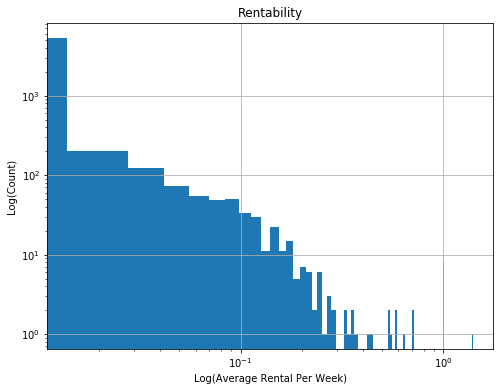

In [9]:
# Rentability distribution
fig, ax = plt.subplots(figsize=(8, 6))

data.query('rental_frequency < 2').hist(column='rental_frequency', ax=ax, bins=100)

plt.title('Rentability')

plt.xlabel('Log(Average Rental Per Week)')
plt.ylabel('Log(Count)')

ax.set_yscale('log')
ax.set_xscale('log');

The vast majority of the rental items are under utilized and for this reason we classify them all as "**Low**" performing inventory. Removing these items we can explore the rest of the items to see if there are any additional structures in the rentability distribution.

In [10]:
# Rentability of all items that have been rented at least once
rental_freq = data.query('rental_frequency!=0')['rental_frequency']\
                  .sort_values(ascending=True)

In [11]:
# Total number of items that have been rented at least once
len(rental_freq)

944

As we see, there are 944 items that have been rented at some point. A good choice would be to classify the top 50% of the inventory with high rentability as "**High**" performing and the lower 50% of the inventory as "**Moderate**" performing. The next step is to determine what rentability threshold value will accomplish this classification. The motivation behind chosing 50% was to ensure that each rentability classification will have enough statistics for our modeling. The data is already imbalanced and chosing an 80/20 split would make it even that much more for the high rentability inventory.

In [12]:
# Half the inventory
half = int(944/2)

print(rental_freq.values[half-1])
print(rental_freq.values[half])

0.0340356564019449
0.03431372549019608


The threshold value should be between 0.03404 and 0.03431 so we wil use is **0.034175**. Samples that have a rentability of zero will be labeled by 0 (Low performing), while those with a rentability within (0, 0.034175) will be labeled by 1 (Moderately performing), and those with a rentability greater than 0.034175 will be labeled by 2 (High performing). We have now modeled the problem as a **Multi-class classification**.

In [13]:
# Categorize Rentability

rental_frequency_treshold = 0.034175 # (50th percentile)

f = lambda df: 0 if df['rental_frequency']==0 \
                 else (1 if df['rental_frequency'] < rental_frequency_treshold \
                       else 2)

data['rental_category'] = data.apply(f, axis=1)

In [14]:
# Validating the rental category composition

data.groupby(['rental_category']).count()['id']

rental_category
0    5145
1     472
2     472
Name: id, dtype: int64

This is what we would expect the majority of the inventory is low performing (i.e. 0) while the rest is equally distributed as either moderately performing (i.e. 1) or high performing (i.e. 2).

# One-Hot Encoding Categorical Features

The last transformation we preform is One-Hot-Encoding of categorical features into numerical values in order for machine learning algorithms to be able to utilize them. The categorical features in our analysis are "item type", "brand", "size", and "rental price".

In [15]:
X_raw = data[['item_type', 'brand', 'size', 'rental_price']]
X_ohe = pd.get_dummies(X_raw[['brand', 'item_type']], prefix=['brand', 'item_type'])

The final data is therefore stored in X, and y.

In [16]:
X = X_raw[['size', 'rental_price']].join(X_ohe)
y = data['rental_category']

In [16]:
X.to_csv(path_or_buf='data/X.csv', sep=',', header=True,
         index=True, index_label=None, mode='w',
         line_terminator='\n')

y.to_csv(path='data/y.csv', sep=',', header=True,
         index=True, index_label=None, mode='w')